In [1]:
# Настраиваем импорты.
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
from PyQt5.QtWidgets.QGridLayout import originCorner

In [2]:
# Включаем интерактивный режим (для отображения графиков.
%matplotlib inline

In [3]:
# Включаем автозаполнение.
%config Completer.use_jedi = False

In [4]:
# Вводные.
trainPath = 'data/exam_module_4/1_variant_dna_sequence_mutation_prediction/input/train.csv'
testPath = 'data/exam_module_4/1_variant_dna_sequence_mutation_prediction/input/test.csv'
cvFraction = 0.15
randomCeed = 777

In [5]:
# 1. Определяем тип задачи.

In [6]:
print('Task type: logistic regression or SVM')

Task type: logistic regression or SVM


In [7]:
# 2. Создаём фреймы и выделяем часть датасета на CV.

In [8]:
#Смотрим огригинальные тренировочные данные.
originalTrainDf = pd.read_csv(trainPath)
originalTrainDf.info()
originalTrainDf.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180000 entries, 0 to 179999
Data columns (total 32 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   ID         180000 non-null  int64  
 1   sequence1  180000 non-null  object 
 2   sequence2  180000 non-null  object 
 3   sequence3  180000 non-null  object 
 4   sequence4  180000 non-null  object 
 5   sequence5  180000 non-null  object 
 6   sequence6  180000 non-null  object 
 7   sequence7  180000 non-null  object 
 8   sequence8  180000 non-null  object 
 9   sequence9  180000 non-null  object 
 10  A          180000 non-null  int64  
 11  B          180000 non-null  int64  
 12  C          180000 non-null  int64  
 13  D          180000 non-null  int64  
 14  E          180000 non-null  int64  
 15  F          180000 non-null  int64  
 16  G          180000 non-null  int64  
 17  H          180000 non-null  int64  
 18  I          180000 non-null  int64  
 19  J          180000 non-n

,ID,sequence1,sequence2,sequence3,sequence4,sequence5,sequence6,sequence7,sequence8,sequence9,...,M,N,O,P,Q,R,S,T,U,mutation
0,0,ATGCGCTTAATT,ATGCGCTTAATT,ATGCGCTTAATT,ATGCGCTTAATT,ATGCGCTTAATT,AAATCAGCTAAA,ATTCCATATTTT,ATTCCATATTTT,AAATCAGCTAAA,...,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915,0
1,2,ATGCGCTTAATT,ATGCGCTTAATT,GATCGTAGCTAA,ATGCGCTTAATT,ATGCGCTTAATT,AAATCAGCTAAA,ATTCCATATTTT,ATTCCATATTTT,AAATCAGCTAAA,...,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452,0
2,5,ATGCGCTTAATT,ATGCGCTTAATT,ATGCGCTTAATT,ATGCGCTTAATT,ATGCGCTTAATT,AAATCAGCTAAA,ATTCCATATTTT,ATTCCATATTTT,AAATCAGCTAAA,...,0.524760,0.580085,0.301498,0.261055,0.193988,0.935688,0.685868,0.277694,0.428115,0
3,7,ATGCGCTTAATT,ATGCGCTTAATT,ATGCGCTTAATT,ATGCGCTTAATT,ATGCGCTTAATT,ATTCCATATTTT,AAATCAGCTAAA,TAACATACAGAG,TAACATACAGAG,...,0.943545,0.209744,0.670577,0.772650,0.845751,0.507320,0.927204,0.605755,0.454155,1
4,9,ATGCGCTTAATT,GATCGTAGCTAA,ATGCGCTTAATT,GATCGTAGCTAA,GATCGTAGCTAA,ATTCCATATTTT,AAATCAGCTAAA,ATTCCATATTTT,TAACATACAGAG,...,0.397622,0.506096,0.200673,0.734145,0.521673,0.365571,0.416094,0.584799,0.447149,1


In [9]:
#Смотрим огригинальные тренировочные данные.
originalTestDf = pd.read_csv(testPath)
originalTestDf.info()
originalTestDf.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 31 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   ID         120000 non-null  int64  
 1   sequence1  120000 non-null  object 
 2   sequence2  120000 non-null  object 
 3   sequence3  120000 non-null  object 
 4   sequence4  120000 non-null  object 
 5   sequence5  120000 non-null  object 
 6   sequence6  120000 non-null  object 
 7   sequence7  120000 non-null  object 
 8   sequence8  120000 non-null  object 
 9   sequence9  120000 non-null  object 
 10  A          120000 non-null  int64  
 11  B          120000 non-null  int64  
 12  C          120000 non-null  int64  
 13  D          120000 non-null  int64  
 14  E          120000 non-null  int64  
 15  F          120000 non-null  int64  
 16  G          120000 non-null  int64  
 17  H          120000 non-null  int64  
 18  I          120000 non-null  int64  
 19  J          120000 non-n

,ID,sequence1,sequence2,sequence3,sequence4,sequence5,sequence6,sequence7,sequence8,sequence9,...,L,M,N,O,P,Q,R,S,T,U
0,1,ATGCGCTTAATT,ATGCGCTTAATT,GATCGTAGCTAA,ATGCGCTTAATT,GATCGTAGCTAA,ATTCCATATTTT,AAATCAGCTAAA,ATTCCATATTTT,AAATCAGCTAAA,...,0.328929,0.386385,0.541366,0.388982,0.357778,0.600044,0.408701,0.399353,0.927406,0.493729
1,3,ATGCGCTTAATT,ATGCGCTTAATT,ATGCGCTTAATT,ATGCGCTTAATT,ATGCGCTTAATT,AAATCAGCTAAA,ATTCCATATTTT,ATTCCATATTTT,AAATCAGCTAAA,...,0.707663,0.831147,0.807807,0.800032,0.619147,0.221789,0.897617,0.633669,0.760318,0.934242
2,4,ATGCGCTTAATT,ATGCGCTTAATT,ATGCGCTTAATT,ATGCGCTTAATT,GATCGTAGCTAA,AAATCAGCTAAA,AAATCAGCTAAA,ATTCCATATTTT,AAATCAGCTAAA,...,0.274514,0.338818,0.277308,0.610578,0.128291,0.578764,0.279167,0.351103,0.357084,0.328960
3,6,ATGCGCTTAATT,ATGCGCTTAATT,ATGCGCTTAATT,ATGCGCTTAATT,GATCGTAGCTAA,ATTCCATATTTT,ATTCCATATTTT,ATTCCATATTTT,AAATCAGCTAAA,...,0.707840,0.678466,0.747125,0.678212,0.553609,0.281719,0.768782,0.688580,0.320699,0.642256
4,8,GATCGTAGCTAA,ATGCGCTTAATT,ATGCGCTTAATT,ATGCGCTTAATT,ATGCGCTTAATT,AAATCAGCTAAA,ATTCCATATTTT,ATTCCATATTTT,AAATCAGCTAAA,...,0.664718,0.635195,0.672264,0.561127,0.419873,0.508550,0.673267,0.356103,0.471519,0.499554


In [10]:
#Формируем датафреймы из псевдорандомных выборок.
trainDf = originalTrainDf.sample(frac=(1 - cvFraction), random_state=randomCeed).drop('mutation', axis=1)
trainDfTarget = originalTrainDf.sample(frac=(1 - cvFraction), random_state=randomCeed)[['ID', 'mutation']]
cvDf = originalTrainDf.drop(trainDf.index).drop('mutation', axis=1)
cvDfTarget = originalTrainDf.drop(trainDfTarget.index)[['ID', 'mutation']]
testDf = originalTestDf

In [11]:
print('Original train data:')
pd.read_csv(trainPath).shape

Original train data:


(180000, 32)

In [12]:
print('Original test data:')
pd.read_csv(testPath).shape

Original test data:


(120000, 31)

In [13]:
print('Train data:')
trainDf.shape

Train data:


(153000, 31)

In [14]:
print('Train target data:')
trainDfTarget.shape

Train target data:


(153000, 2)

In [15]:
print('CV data:')
cvDf.shape

CV data:


(27000, 31)

In [16]:
print('CV target data:')
cvDfTarget.shape

CV target data:


(27000, 2)

In [17]:
print('Test data:')
testDf.shape

Test data:


(120000, 31)

In [18]:
# 3. Определяем тип переменных в датасете.

In [19]:
print('Train data types:')
trainDf.info()
print('Train target data types:')
trainDfTarget.info()

Train data types:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 153000 entries, 105497 to 170866
Data columns (total 31 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   ID         153000 non-null  int64  
 1   sequence1  153000 non-null  object 
 2   sequence2  153000 non-null  object 
 3   sequence3  153000 non-null  object 
 4   sequence4  153000 non-null  object 
 5   sequence5  153000 non-null  object 
 6   sequence6  153000 non-null  object 
 7   sequence7  153000 non-null  object 
 8   sequence8  153000 non-null  object 
 9   sequence9  153000 non-null  object 
 10  A          153000 non-null  int64  
 11  B          153000 non-null  int64  
 12  C          153000 non-null  int64  
 13  D          153000 non-null  int64  
 14  E          153000 non-null  int64  
 15  F          153000 non-null  int64  
 16  G          153000 non-null  int64  
 17  H          153000 non-null  int64  
 18  I          153000 non-null  int64  
 19  

In [20]:
# 4. Если это необходимо провести препроцессинг данных, нужно ли применять алгоритмы понижения размерности?
# Нужно ли убирать аномалии?

In [21]:
# Переводим первые 9 столбцов в цифры (по методу one-hot, one-hot столбцы добавляются в конце датафрейма).
dummieCounter = 0
for col in trainDf.columns:
    if trainDf[col].dtypes == object:
        dummieCounter += len(trainDf[col].unique())
        print('Unique in ' + str(col) + ': ' + str(len(trainDf[col].unique())))
print('Dummie columns: ' + str(dummieCounter))

trainDf = pd.get_dummies(trainDf)
cvDf = pd.get_dummies(cvDf)
testDf = pd.get_dummies(testDf)

Unique in sequence1: 2
Unique in sequence2: 2
Unique in sequence3: 2
Unique in sequence4: 2
Unique in sequence5: 2
Unique in sequence6: 4
Unique in sequence7: 4
Unique in sequence8: 4
Unique in sequence9: 4
Dummie columns: 26


In [22]:
print("TrainDF: ")
trainDf.shape

TrainDF: 


(153000, 48)

In [23]:
print('CvDF: ')
cvDf.shape

CvDF: 


(27000, 48)

In [24]:
print("TestDF: ")
testDf.shape

TestDF: 


(120000, 48)

In [25]:
def time_series_plot(df):
    """Given dataframe, generate times series plot of numeric data by daily, monthly and yearly frequency"""
    print("\nTo check time series of numeric data  by daily, monthly and yearly frequency")
    if len(df.select_dtypes(include='datetime64').columns) > 0:
        for col in df.select_dtypes(include='datetime64').columns:
            for p in ['D', 'M', 'Y']:
                if p == 'D':
                    print("Plotting daily data")
                elif p == 'M':
                    print("Plotting monthly data")
                else:
                    print("Plotting yearly data")
                for col_num in df.select_dtypes(include=np.number).columns:
                    __ = df.copy()
                    __ = __.set_index(col)
                    __T = __.resample(p).sum()
                    ax = __T[[col_num]].plot()
                    ax.set_ylim(bottom=0)
                    ax.get_yaxis().set_major_formatter(
                        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
                    plt.show()


def numeric_eda(df, hue=None):
    """Given dataframe, generate EDA of numeric data"""
    print("\nTo check: \nDistribution of numeric data")
    display(df.describe().T)
    columns = df.select_dtypes(include=np.number).columns
    figure = plt.figure(figsize=(20, 10))
    figure.add_subplot(1, len(columns), 1)
    for index, col in enumerate(columns):
        if index > 0:
            figure.add_subplot(1, len(columns), index + 1)
        sns.boxplot(y=col, data=df, boxprops={'facecolor': 'None'})
    figure.tight_layout()
    plt.show()

    if len(df.select_dtypes(include='category').columns) > 0:
        for col_num in df.select_dtypes(include=np.number).columns:
            for col in df.select_dtypes(include='category').columns:
                fig = sns.catplot(x=col, y=col_num, kind='violin', data=df, height=5, aspect=2)
                fig.set_xticklabels(rotation=90)
                plt.show()

    # Plot the pairwise joint distributions
    print("\nTo check pairwise joint distribution of numeric data")
    if hue == None:
        sns.pairplot(df.select_dtypes(include=np.number))
    else:
        sns.pairplot(df.select_dtypes(include=np.number).join(df[[hue]]), hue=hue)
    plt.show()


def top5(df):
    """Given dataframe, generate top 5 unique values for non-numeric data"""
    columns = df.select_dtypes(include=['object', 'category']).columns
    for col in columns:
        print("Top 5 unique values of " + col)
        print(df[col].value_counts().reset_index().rename(columns={"index": col, col: "Count"})[
              :min(5, len(df[col].value_counts()))])
        print(" ")


def categorical_eda(df, hue=None):
    """Given dataframe, generate EDA of categorical data"""
    print("\nTo check: \nUnique count of non-numeric data\n")
    print(df.select_dtypes(include=['object', 'category']).nunique())
    top5(df)
    # Plot count distribution of categorical data
    for col in df.select_dtypes(include='category').columns:
        fig = sns.catplot(x=col, kind="count", data=df, hue=hue)
        fig.set_xticklabels(rotation=90)
        plt.show()


def eda(df):
    """Given dataframe, generate exploratory data analysis"""
    # check that input is pandas dataframe
    if type(df) != pd.core.frame.DataFrame:
        raise TypeError("Only pandas dataframe is allowed as input")

    # replace field that's entirely space (or empty) with NaN
    df = df.replace(r'^\s*$', np.nan, regex=True)

    print("Preview of data:")
    display(df.head(3))

    print("\nTo check: \n (1) Total number of entries \n (2) Column types \n (3) Any null values\n")
    print(df.info())

    # generate preview of entries with null values
    if df.isnull().any(axis=None):
        print("\nPreview of data with null values:")
        display(df[df.isnull().any(axis=1)].head(3))
        missingno.matrix(df)
        plt.show()

    # generate count statistics of duplicate entries
    if len(df[df.duplicated()]) > 0:
        print("\n***Number of duplicated entries: ", len(df[df.duplicated()]))
        display(df[df.duplicated(keep=False)].sort_values(by=list(df.columns)).head())
    else:
        print("\nNo duplicated entries found")

    print('cat')
    # EDA of categorical data
    categorical_eda(df)

    print('num')
    # EDA of numeric data
    numeric_eda(df)
    print('time')
    # Plot time series plot of numeric data
    time_series_plot(df)

Preview of data:


,ID,A,B,C,D,E,F,G,H,I,...,sequence7_GTCATGCACCCT,sequence7_TAACATACAGAG,sequence8_AAATCAGCTAAA,sequence8_ATTCCATATTTT,sequence8_GTCATGCACCCT,sequence8_TAACATACAGAG,sequence9_AAATCAGCTAAA,sequence9_ATTCCATATTTT,sequence9_GTCATGCACCCT,sequence9_TAACATACAGAG
105497,176114,5,3,0,7,33,0,22,45,0,...,0,0,0,1,0,0,0,0,0,1
151648,252874,8,2,0,3,2,0,46,28,0,...,0,0,0,1,0,0,1,0,0,0
173456,289103,8,0,1,4,28,0,8,51,0,...,0,0,0,1,0,0,1,0,0,0



To check: 
 (1) Total number of entries 
 (2) Column types 
 (3) Any null values

<class 'pandas.core.frame.DataFrame'>
Int64Index: 153000 entries, 105497 to 170866
Data columns (total 48 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   ID                      153000 non-null  int64  
 1   A                       153000 non-null  int64  
 2   B                       153000 non-null  int64  
 3   C                       153000 non-null  int64  
 4   D                       153000 non-null  int64  
 5   E                       153000 non-null  int64  
 6   F                       153000 non-null  int64  
 7   G                       153000 non-null  int64  
 8   H                       153000 non-null  int64  
 9   I                       153000 non-null  int64  
 10  J                       153000 non-null  int64  
 11  K                       153000 non-null  float64
 12  L                       153000 non-null 

,count,mean,std,min,25%,50%,75%,max
ID,153000.0,150144.902484,86578.142970,2.000000,75255.750000,150068.000000,225217.250000,299999.000000
A,153000.0,8.119144,3.081981,0.000000,7.000000,8.000000,10.000000,14.000000
B,153000.0,2.636536,4.148628,0.000000,0.000000,0.000000,3.000000,18.000000
C,153000.0,0.617320,1.187438,0.000000,0.000000,0.000000,1.000000,12.000000
D,153000.0,4.805908,1.519956,0.000000,4.000000,4.000000,5.000000,19.000000
E,153000.0,29.705235,12.705741,0.000000,33.000000,33.000000,33.000000,83.000000
F,153000.0,1.260980,2.106283,0.000000,0.000000,0.000000,2.000000,15.000000
G,153000.0,23.547072,13.899673,0.000000,9.000000,23.000000,35.000000,50.000000
H,153000.0,33.436634,18.986059,0.000000,19.000000,38.000000,49.000000,60.000000
I,153000.0,1.604529,2.752843,0.000000,0.000000,0.000000,2.000000,18.000000


/tmp/ipykernel_297846/919600438.py:35: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  figure.tight_layout()


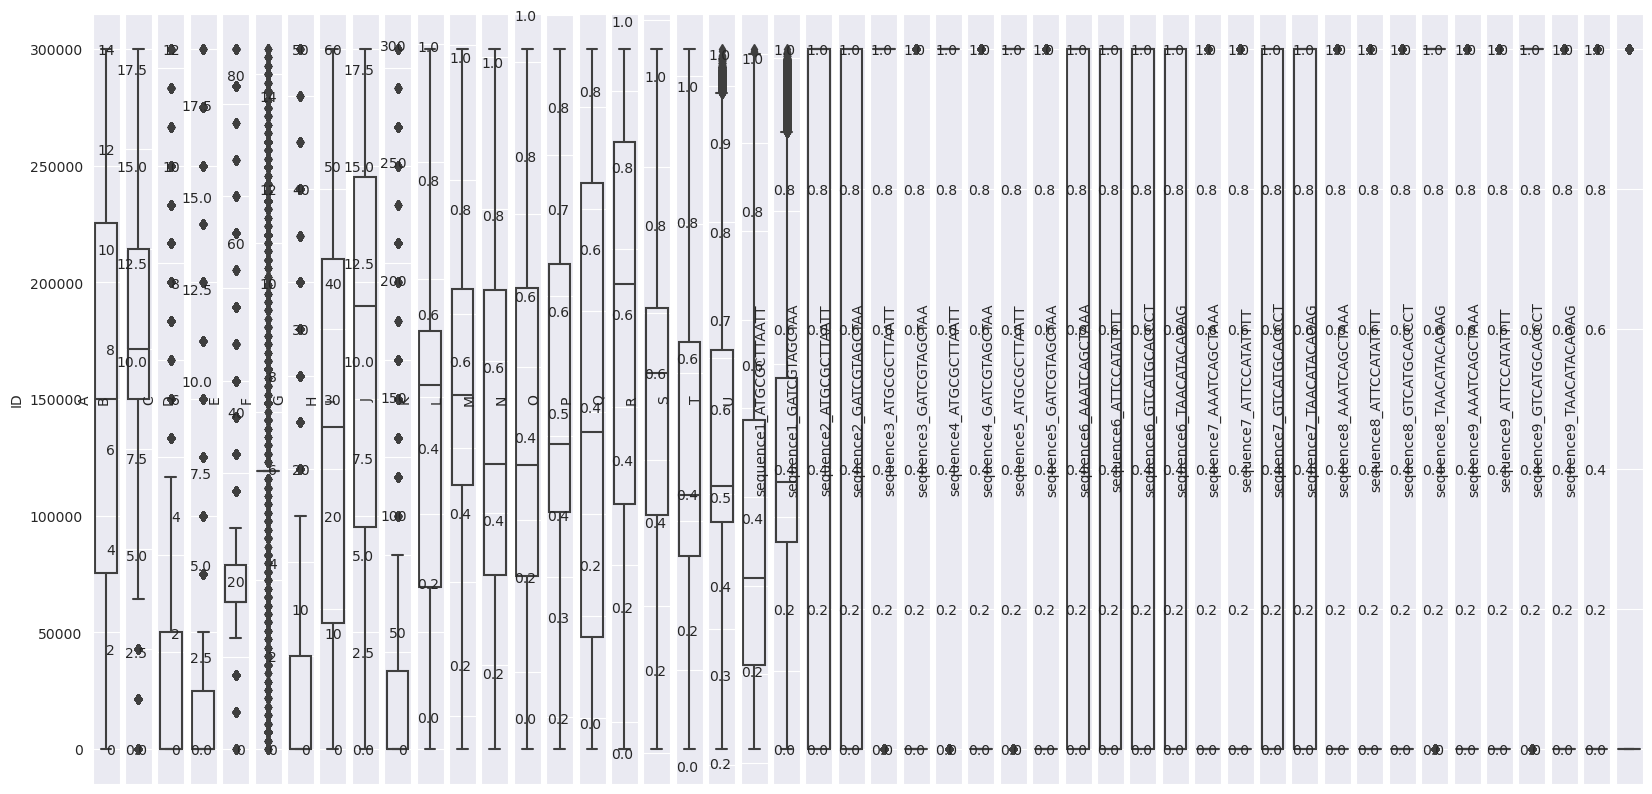


To check pairwise joint distribution of numeric data


In [ ]:
eda(trainDf)

In [ ]:
# 5. Провести EDA и вывести какие-то умозаключения и посмотреть на распределения признаков, на корреляции, на выбросы.

In [ ]:
# 6. Подумать над вариантом модели, для того чтобы решить задачу (либо ансамблем моделей)

In [ ]:
print('Так как n << m, лучше использовать логистическую регрессию, либо SMV without kernel.')

In [ ]:
# 7. Подумать нужно ли применять Unsupervised learning подход для решения задачи?
# Неоходима ли дополнительная информация?

In [ ]:
# 8. Обучить модель и вывести валидационный скор по метрике качества.